In [23]:
####Rene 7_30_2021 update 4/1/2022
# Import the os module
import os
import pandas as pd
import numpy as np

#Generate clusters of ms features across depth.
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

#This file is for development. Main functions are embedded here.

# Change the current working directory
os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')

###### Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/HRMS acquisition/Thermo waters comparison'
files=os.listdir('/Users/boiteaur/Desktop/HRMS acquisition/Thermo waters comparison')

import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("./")
from pathlib import Path
import matplotlib.pyplot as plt


from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import matplotlib.backends.backend_pdf

refmasslist = Path.cwd() / "tests/tests_data/ftms/nom_pos_2.ref"

#Set peak detection threshold method
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 10
MSParameters.ms_peak.peak_min_prominence_percent = 0.01

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -1
MSParameters.molecular_search.max_ppm_error = 1

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,8)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"
#Read in sample list and load MS data

afile="082422_10_POS_OC2102A_Sample361_1uMB12_Stn12"
bfile="x_rmb_20220630_fp_OC2102A_s948_132"
MSfiles={}

parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+afile)
bparser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+bfile)

MSfiles[afile]=parser
MSfiles[bfile]=bparser


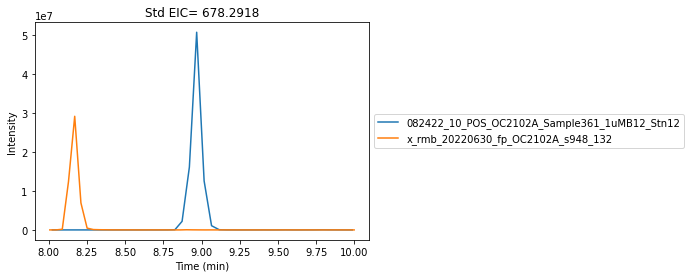

In [15]:
#QC control 

stdmass=678.2918
std_timerange=[8,10]

#QC control 

#stdmass=389.1960
#std_timerange=[5,30]

area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('Fig1_qcplot.eps', format='eps')

plt.show()



In [16]:
#Function to build formula assignment lists
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 
interval=2
timerange=[12,16]

B=21 #magnetic field strength
T=0.6 #transient time

def lcmsformula(parser,interval,timerange):
    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)

    
        #### Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
        
        # mass_spectrum.filter_by_min_resolving_power(B, T)
        mass_spectrum.settings.min_calib_ppm_error = 3
        mass_spectrum.settings.max_calib_ppm_error = -3

        calfn = MzDomainCalibration(mass_spectrum, refmasslist)
        ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

        imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                    calib_ppm_error_threshold=(-3.0, 3.0),
                                                    calib_snr_threshold=7)

        calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)

        #### Now assign formula

        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
        #results(timestart)=assignments[assignments['Calculated m/z']>1].filter(['m/z','corr','Peak Height','Confidence Score','Molecular Formula','Time']))
    
    results=pd.concat(results,ignore_index=True)

    return(results)

In [17]:
#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
masterresults_df.to_csv(file_location+'masterresults_5.csv')

082422_10_POS_OC2102A_Sample361_1uMB12_Stn12
MS Obj loaded - 633 peaks found.
MS Obj loaded - 633 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
269 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.197 ppm
minimize function performed 251 fn evals and 3 iterations
'runworker'  1506.98 ms


Loading molecular formula database: 140096it [00:13, 10765.66it/s]
Started molecular formula search for class {"N": 8, "O": 20}, (de)protonated : 100%|██████████| 180/180 [00:02<00:00, 76.54it/s] 


'run_molecular_formula'  17044.05 ms
581 assigned peaks and 52 unassigned peaks, total  = 91.79 %, relative abundance = 92.79 %, RMS error (best candidate) (ppm) = 0.281
MS Obj loaded - 580 peaks found.
MS Obj loaded - 580 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
184 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.193 ppm
minimize function performed 250 fn evals and 3 iterations
'runworker'  1371.36 ms


Loading molecular formula database: 140096it [00:11, 11758.80it/s]
Started molecular formula search for class {"N": 8, "O": 20}, (de)protonated : 100%|██████████| 180/180 [00:02<00:00, 73.11it/s] 


'run_molecular_formula'  15925.53 ms
521 assigned peaks and 59 unassigned peaks, total  = 89.83 %, relative abundance = 73.69 %, RMS error (best candidate) (ppm) = 0.282
x_rmb_20220630_fp_OC2102A_s948_132
MS Obj loaded - 657 peaks found.
MS Obj loaded - 657 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
163 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.134 ppm
minimize function performed 831 fn evals and 20 iterations
'runworker'  698.21 ms


Loading molecular formula database: 140096it [00:10, 12964.79it/s]
Started molecular formula search for class {"N": 8, "O": 20}, (de)protonated : 100%|██████████| 180/180 [00:02<00:00, 82.30it/s] 


'run_molecular_formula'  13821.23 ms
564 assigned peaks and 93 unassigned peaks, total  = 85.84 %, relative abundance = 80.96 %, RMS error (best candidate) (ppm) = 0.281
MS Obj loaded - 257 peaks found.
MS Obj loaded - 257 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
27 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.086 ppm
minimize function performed 314 fn evals and 6 iterations
'runworker'  962.52 ms


Loading molecular formula database: 140096it [00:08, 16905.06it/s]
Started molecular formula search for class {"N": 8, "O": 20}, (de)protonated : 100%|██████████| 180/180 [00:00<00:00, 191.52it/s]


'run_molecular_formula'  10301.21 ms
241 assigned peaks and 16 unassigned peaks, total  = 93.77 %, relative abundance = 94.94 %, RMS error (best candidate) (ppm) = 0.175


In [ ]:
#masterresults_df=pd.concat(masterresults.values())
#masterresults_df.to_csv(file_location+'masterresults_2.csv')

Text(0, 0.5, 'Fraction of peaks resolved')

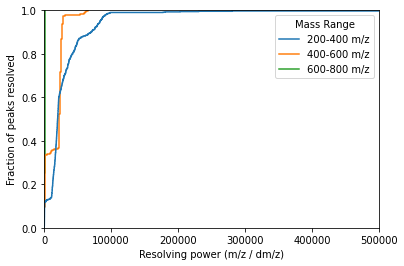

In [18]:
#Make plots showing required resolving power.

#This will load a previous masterresults_df
masterresults_df=pd.read_csv(file_location+'masterresults_5.csv')

#Note, this line filters masterresults to only contain samples.
#masterresults_df=masterresults_df[masterresults_df.File.isin(samplelist.File[samplelist.type=='sample'])]

#Calculate required resolving power
res_summary=[]
mzinterval=200
mzint=range(200,800,mzinterval)
for time in masterresults_df['Time'].unique():
    
    result=masterresults_df[masterresults_df['Time']==time]

    for file in masterresults_df['File'].unique():

        result_sub=result[result['File']==file]

        for mz in mzint:
            result_sub_mz=result_sub[(result_sub['m/z']>mz) & (result_sub['m/z'] < mz + mzinterval)]
            mzvalues=result_sub_mz['m/z'].sort_values(ascending=True)
            differences=mzvalues.diff()
            #Resolve from peaks on either side
            mzdiff=pd.DataFrame({'left':differences[1:-1].to_list(),'right':differences[2:].to_list()})
            mzdiff=mzdiff.min(axis=1)
            mzvalues=mzvalues.iloc[1:-1].reset_index()['m/z']
            #mzdiff_res=mzvalues/mzdiff*2
            mzdiff_res=mzvalues/mzdiff*2
            for i in mzdiff_res.index:
                res_summary.append({'resolution':mzdiff_res[i],'mass':mzvalues[i],'Mass Range':str(mz)+'-'+str(mz+mzinterval) + ' m/z','file':file,'time':time})

res_summary_df=pd.DataFrame(res_summary)
fig, (ax) = plt.subplots(1)
sns.ecdfplot(x='resolution',hue='Mass Range',data=res_summary_df,ax=ax)
ax.set_xlim(0,500000)
ax.set_xlabel('Resolving power (m/z / dm/z)')
ax.set_ylabel('Fraction of peaks resolved')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


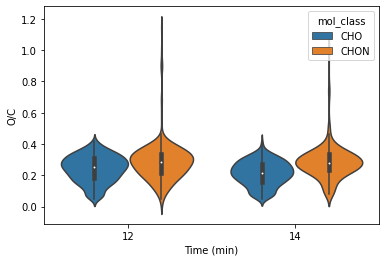

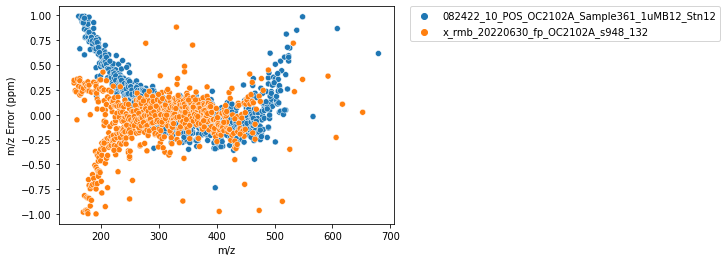

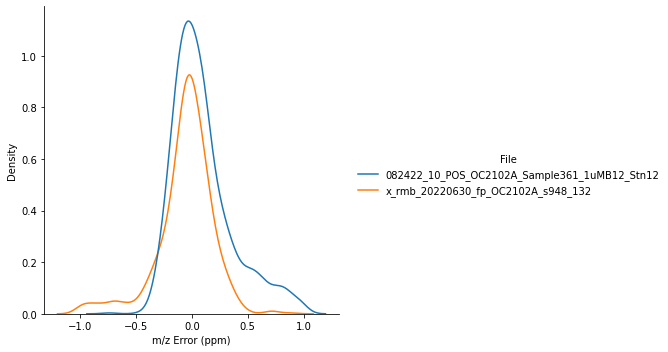

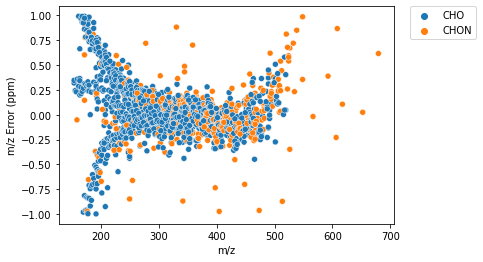

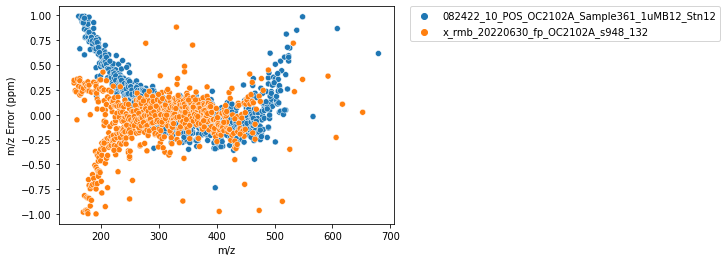

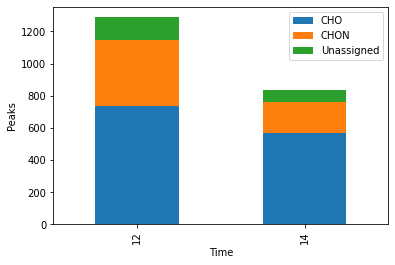

In [19]:
# Plot clean results. 

allresults=masterresults_df[(masterresults_df['m/z']<800)]

allresults['N']=allresults['N'].fillna(0)
allresults['O']=allresults['O'].fillna(0)

allresults['Peak Height']=allresults['Peak Height'].fillna(0)
#allresults['S']=allresults['S'].fillna(0)
#allresults['P']=allresults['P'].fillna(0)
#allresults['Na']=allresults['Na'].fillna(0)

allresults['mol_class']='Unassigned'
allresults['mol_class'][allresults['C']>0]='CHO'
allresults['mol_class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'
#allresults['mol_class'][(allresults['C']>0) & (allresults['S']>0.5)]='CHOS'
#allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5)]='CHOP'
#allresults['mol_class'][(allresults['C']>0) & (allresults['Na']>0.5)]='CHONa'
#allresults['mol_class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['N']>0.5)]='CHONS'
#allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['N']>0.5)]='CHONP'
#allresults['mol_class'][(allresults['C']>0) & (allresults['Na']>0.5) & (allresults['N']>0.5)]='CHONNa'
#allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['Na']>0.5) & (allresults['N']>0.5)]='CHONPNa'


results= allresults[allresults['Is Isotopologue']==0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']


fig, (ax) = plt.subplots(1)
sns.violinplot(x="Time", y="O/C", hue='mol_class', data=results, ax=ax)

ax.set(xlabel='Time (min)')

fig, (ax) = plt.subplots(1)
sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='File',data=results,ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax=g=sns.displot(x='m/z Error (ppm)',data=results,hue='File',ax=ax,kind="kde")


fig, (ax) = plt.subplots(1)
sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='mol_class',data=results,ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, (ax) = plt.subplots(1)
sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='File',data=results,ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

 
assign_summary=[]
for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['mol_class'].unique()):
        current[mol_class]=len(allresults[(allresults['mol_class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')

plt.show()



In [ ]:
calc=pd.DataFrame(assign_summary)
fraction_Assigned=calc.Unassigned/(calc.CHO+calc.CHON+calc.Unassigned)
print(fraction_Assigned)

All results length: 2127
Monoisotopic results length: 1767
All Unique results: 1213
Unique results, min thresh: 1213
Unique molecular formula: 787


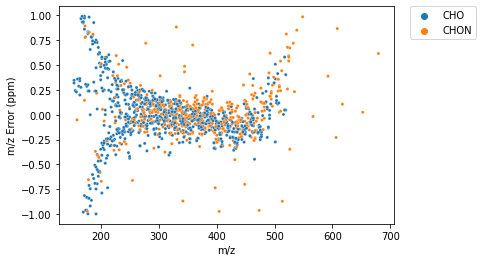

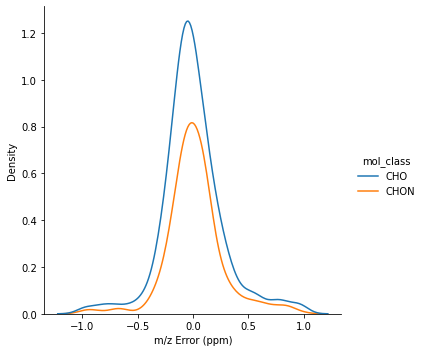

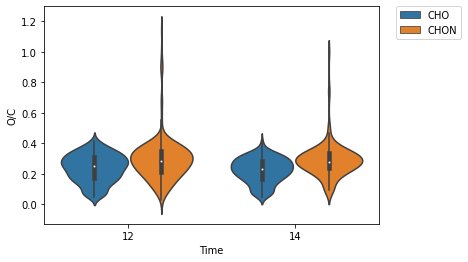

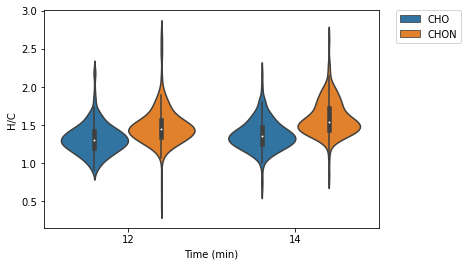

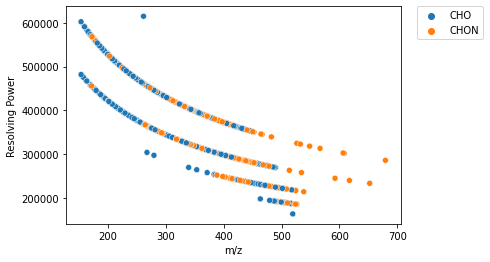

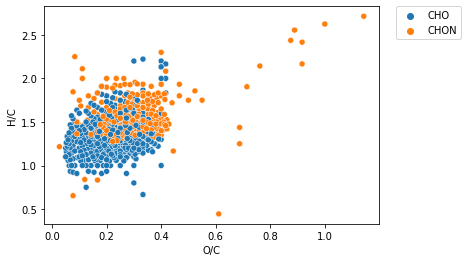

In [20]:
print("All results length: " + str(len(allresults)))
print("Monoisotopic results length: " + str(len(results)))

#Create a list of all unique features and their abundances across samples. . 
uniquelist=[]
for time in results.Time.unique():
    current=results[results.Time==time]
    current=current.sort_values(by=['S/N'],ascending=False)
    currentunique=current.drop_duplicates(subset=['Molecular Formula'])
    currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
    for file in results['File'].unique():
        #current_file=current[current['File']==file].drop_duplicates(subset=['Molecular Formula'])
        #print(len(current))
        current_file=current[current['File']==file]
        #print(len(current))
        current_file=current_file.rename(columns={'Peak Height':file})
        current_file=current_file.set_index(['Molecular Formula'],drop=False)
        currentunique=currentunique.join(current_file[file])
    uniquelist.append(currentunique)

uniqueresults=pd.concat(uniquelist,ignore_index=True)
print("All Unique results: " + str(len(uniqueresults)))


print("Unique results, min thresh: " + str(len(uniqueresults)))
print("Unique molecular formula: " + str(len(uniqueresults['Molecular Formula'].unique())))

fig, (ax) = plt.subplots(1)
ax=g=sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='mol_class',data=uniqueresults,ax=ax,s=10)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax=g=sns.displot(x='m/z Error (ppm)',data=uniqueresults,hue='mol_class',ax=ax,kind="kde")

fig, (ax) = plt.subplots(1)
ax=sns.violinplot(x="Time", y="O/C", hue='mol_class', data=uniqueresults, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, (ax) = plt.subplots(1)
sns.violinplot(x="Time", y="H/C", hue='mol_class', data=uniqueresults, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set(xlabel='Time (min)')


fig, (ax) = plt.subplots(1)
ax=sns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=uniqueresults,ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, (ax) = plt.subplots(1)
ax=sns.scatterplot(x='O/C',y='H/C',hue='mol_class',data=uniqueresults,ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


#s2n=np.arange(0,10,0.05)
#mzerror=[]

#for s in s2n:
#    curr=uniqueresults[uniqueresults['S/N'] < s]
#    mzerror.append(abs(curr['m/z Error (ppm)']).mean())

#test=pd.DataFrame({'s2n':s2n, 'mzerror':mzerror})

#fig, (ax) = plt.subplots(1)
#sns.lineplot(x='s2n',y='mzerror',data=test,ax=ax)
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#uniqueresults.to_csv(file_location+'grouped_results_for_error_analysis.csv')


1119
470
142
507


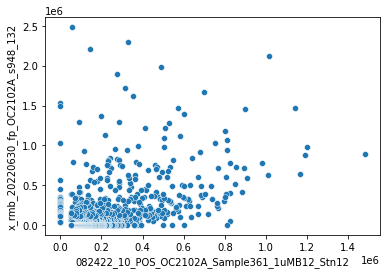

In [24]:
uniqueresults=uniqueresults[uniqueresults['m/z']>200]
#uniqueresults=uniqueresults[uniqueresults['mol_class']=='CHO']

uniqueresults[afile]=uniqueresults[afile].fillna(0)
uniqueresults[bfile]=uniqueresults[bfile].fillna(0)

sns.scatterplot(x=afile, y=bfile, data=uniqueresults)

print(len(uniqueresults))
print(len(uniqueresults[(uniqueresults[afile]>1) & (uniqueresults[bfile]<1)]))
print(len(uniqueresults[(uniqueresults[afile]<1) & (uniqueresults[bfile]>1)]))
print(len(uniqueresults[(uniqueresults[afile]>1) & (uniqueresults[bfile]>1)]))

In [ ]:
#Create a list of all unique features and their abundances across samples. . 

for time in allresults.Time.unique():
    for file in allresults['File'].unique():
        current=allresults[(allresults.Time==time) & (allresults.File==file)]
        isotopes=current[current['is']]
        monoisotopes=
    current=current.sort_values(by=['S/N'],ascending=False)
    currentunique=current.drop_duplicates(subset=['Molecular Formula'])
    currentunique=currentunique.set_index(['Molecular Formula'],drop=False)

In [ ]:
test=allresults[allresults['Is Isotopologue']==1]
sns.histplot(x='Isotopologue Similarity',hue='File',data=test,multiple="dodge")